In [1]:
#Import Library
import numpy as np
import pandas as pd
import seaborn as sns

#Set library parameter
pd.set_option('display.float_format',  '{:.4f}'.format) #set pandas float format
sns.set(rc={'figure.figsize':(11.7,8.27)}) #set sns plot size

#Read dataset format = csv
dataset = pd.read_csv("D:\Danang\database\commodity\commodity_trade_statistics_data.csv")
df_full_data = dataset

C:\Users\Danang Prasetyanto\AppData\Local\Temp\ipykernel_21920\122405721.py:11: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv("D:\Danang\database\commodity\commodity_trade_statistics_data.csv")


In [2]:
#analytical parameter
# function: commsrc_after
full_year = 2012 #must be int
commodity = 'all'

#function: ranks_flow
ranks_flow = 'Import'

#clean category should not included for the current commodity
clean_comm_code = ''

In [3]:
dfc_full = df_full_data.copy() #copy full data to dfc_full dataframe
dfc_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8225871 entries, 0 to 8225870
Data columns (total 10 columns):
 #   Column           Dtype  
---  ------           -----  
 0   country_or_area  object 
 1   year             int64  
 2   comm_code        object 
 3   commodity        object 
 4   flow             object 
 5   trade_usd        int64  
 6   weight_kg        float64
 7   quantity_name    object 
 8   quantity         float64
 9   category         object 
dtypes: float64(2), int64(2), object(6)
memory usage: 627.6+ MB


In [4]:
dfc_full['comm_code'] = dfc_full['comm_code'].astype(str)
dfc_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8225871 entries, 0 to 8225870
Data columns (total 10 columns):
 #   Column           Dtype  
---  ------           -----  
 0   country_or_area  object 
 1   year             int64  
 2   comm_code        object 
 3   commodity        object 
 4   flow             object 
 5   trade_usd        int64  
 6   weight_kg        float64
 7   quantity_name    object 
 8   quantity         float64
 9   category         object 
dtypes: float64(2), int64(2), object(6)
memory usage: 627.6+ MB


In [5]:
dfc_full['quantity_name'].value_counts()

Weight in kilograms                                 6617980
Number of items                                      709321
No Quantity                                          505176
Volume in litres                                     144599
Area in square metres                                135912
Number of pairs                                       67929
Length in metres                                      18225
Volume in cubic meters                                17775
Weight in carats                                       5237
Thousands of items                                     1386
Electrical energy in thousands of kilowatt-hours       1264
Number of packages                                     1067
Name: quantity_name, dtype: int64

In [6]:
a = dfc_full['year'].value_counts()
a = a.reset_index()
a.sort_values('index').head(5)

,index,year
28,1988,30997
27,1989,63933
26,1990,72272
25,1991,83951
24,1992,121214


In [7]:
#create function to search commodity and Import-export flow, use all to take all the flow
def commsrc_after(comm,after):
    if comm != 'all':
        commsearch = dfc_full[dfc_full['commodity'].str.contains(comm,regex=True,na=False)]
    else: commsearch = dfc_full[dfc_full['comm_code'] != 'TOTAL'] 
    temp = commsearch[commsearch['year'] >= after]
    return (temp)

def ranks(comm_eda,flow):
    if flow != 'all':
        dfc_eda = comm_eda[comm_eda['flow'] == flow]
    else: dfc_eda == comm_eda

    dfc_eda = dfc_eda.groupby(['category','comm_code','commodity','country_or_area','quantity_name','year','flow'],as_index=False)['weight_kg','trade_usd','quantity'].sum() #to aggregate weight and trade usd
    dfc_eda['average_usd_kg'] = dfc_eda['trade_usd'] / dfc_eda['weight_kg'] #to create column which show average price each year
    dfc_eda['trade_usd_total'] = dfc_eda.groupby(['country_or_area'])['trade_usd'].transform(np.sum) #sum trade_usd over partition by country_or_area
    dfc_eda['weight_kg_total'] = dfc_eda.groupby(['country_or_area'])['weight_kg'].transform(np.sum) #sum weight_kg over partition by country_or_area
    dfc_eda['average_price_years'] = dfc_eda.groupby(['country_or_area'])['average_usd_kg'].transform(np.median) #average average_price_year over partition by country_or_area
    dfc_eda['Rank_trade_usd'] = dfc_eda.trade_usd_total.rank(method='dense',ascending=False).astype(int) #create dense rank for total trade_usd
    dfc_eda['Rank_weight_kg'] = dfc_eda.weight_kg_total.rank(method='dense',ascending=False).astype(int) #create dense rank for total weight_kg
    dfc_eda['Rank_avg_usd_weight'] = dfc_eda.average_price_years.rank(method='dense',ascending=False).astype(int) #create dense rank for average_usd_weight
    return(dfc_eda)

#create function to check top 10 country with the highest price in latest year
def ranks_latest(top_eda,ranks_column,latest_flow):
    temp = top_eda[top_eda['year']==top_eda['year'].max()]
    temp_ranks = ranks(temp,latest_flow)
    df_ranks = temp_ranks[temp_ranks[ranks_column]<=10].sort_values(ranks_column)
    return(df_ranks)

In [8]:
###################### CLEANING PROCESS ################################

#take data for chosen commodity, in all flow and start with chosen year
comm_clean = commsrc_after(commodity,full_year)

#check unique commodity name
a = comm_clean.groupby(['comm_code','commodity','category'],as_index=False)['flow'].count()
a

,comm_code,commodity,category,flow
0,100110,Durum wheat,10_cereals,1155
1,100190,"Wheat except durum wheat, and meslin",10_cereals,1204
2,100200,Rye,10_cereals,723
3,100300,Barley,10_cereals,1132
4,100400,Oats,10_cereals,1111
...,...,...,...,...
4873,970300,"Original sculptures and statuary, in any material",97_works_of_art_collectors_pieces_and_antiques,1448
4874,970400,"Used postage and revenue stamps, first day cov...",97_works_of_art_collectors_pieces_and_antiques,931
4875,970500,Collections and collectors pieces,97_works_of_art_collectors_pieces_and_antiques,1127
4876,970600,Antiques older than one hundred years,97_works_of_art_collectors_pieces_and_antiques,939


In [9]:
comm_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1760215 entries, 0 to 8216658
Data columns (total 10 columns):
 #   Column           Dtype  
---  ------           -----  
 0   country_or_area  object 
 1   year             int64  
 2   comm_code        object 
 3   commodity        object 
 4   flow             object 
 5   trade_usd        int64  
 6   weight_kg        float64
 7   quantity_name    object 
 8   quantity         float64
 9   category         object 
dtypes: float64(2), int64(2), object(6)
memory usage: 147.7+ MB


In [10]:
#drop all index which contain certain comm_code which not relevant with the commodity analyzed
drop = comm_clean[comm_clean['comm_code'] == clean_comm_code].index
comm_clean.drop(drop,inplace=True)

In [11]:
comm_clean[comm_clean['comm_code'] != clean_comm_code]

,country_or_area,year,comm_code,commodity,flow,trade_usd,weight_kg,quantity_name,quantity,category
0,Afghanistan,2016,10410,"Sheep, live",Export,6088,2339.0000,Number of items,51.0000,01_live_animals
1,Afghanistan,2016,10420,"Goats, live",Export,3958,984.0000,Number of items,53.0000,01_live_animals
3,Albania,2016,10290,"Bovine animals, live, except pure-bred breeding",Import,2414533,1114023.0000,Number of items,6853.0000,01_live_animals
4,Albania,2016,10392,"Swine, live except pure-bred breeding > 50 kg",Import,14265937,9484953.0000,Number of items,96040.0000,01_live_animals
5,Albania,2016,10511,"Fowls, live domestic < 185 grams",Import,2671732,254652.0000,Number of items,5629138.0000,01_live_animals
...,...,...,...,...,...,...,...,...,...,...
8216654,Zimbabwe,2013,999999,Commodities not specified according to kind,Import,76863219,NaN,No Quantity,NaN,99_commodities_not_specified_according_to_kind
8216655,Zimbabwe,2013,999999,Commodities not specified according to kind,Export,8696810,NaN,No Quantity,NaN,99_commodities_not_specified_according_to_kind
8216656,Zimbabwe,2013,999999,Commodities not specified according to kind,Re-Export,17932,NaN,No Quantity,NaN,99_commodities_not_specified_according_to_kind
8216657,Zimbabwe,2012,999999,Commodities not specified according to kind,Export,112775,NaN,No Quantity,NaN,99_commodities_not_specified_according_to_kind


In [12]:
#check nan value
comm_clean.isna().sum()

country_or_area         0
year                    0
comm_code               0
commodity               0
flow                    0
trade_usd               0
weight_kg           43301
quantity_name           0
quantity           102239
category                0
dtype: int64

In [13]:
#drop nan value
null_clean = comm_clean[comm_clean['weight_kg'].isna()]
a = null_clean.index
comm_clean.drop(a,inplace=True)

In [14]:
comm_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1716914 entries, 0 to 8209530
Data columns (total 10 columns):
 #   Column           Dtype  
---  ------           -----  
 0   country_or_area  object 
 1   year             int64  
 2   comm_code        object 
 3   commodity        object 
 4   flow             object 
 5   trade_usd        int64  
 6   weight_kg        float64
 7   quantity_name    object 
 8   quantity         float64
 9   category         object 
dtypes: float64(2), int64(2), object(6)
memory usage: 144.1+ MB


In [23]:
#find duplicate value and delete
dupli_clean = comm_clean[comm_clean.duplicated()]
if dupli_clean['flow'].count() <= 0:
    print('No duplicate')
else: comm_clean.drop(dupli_clean,inplace=True)

No duplicate


In [142]:
comm_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1716914 entries, 0 to 8209530
Data columns (total 10 columns):
 #   Column           Dtype  
---  ------           -----  
 0   country_or_area  object 
 1   year             int64  
 2   comm_code        object 
 3   commodity        object 
 4   flow             object 
 5   trade_usd        int64  
 6   weight_kg        float64
 7   quantity_name    object 
 8   quantity         float64
 9   category         object 
dtypes: float64(2), int64(2), object(6)
memory usage: 144.1+ MB


In [148]:
#copy data to do EDA
top_eda = comm_clean.copy()

In [149]:
#Input function to create ranks of corn and Import
dfc_comm_eda = ranks(top_eda,ranks_flow)

#top 10 total trade by value (trade_usd)
top_10_usd = dfc_comm_eda[dfc_comm_eda['Rank_trade_usd']<=10].sort_values('Rank_trade_usd')
#top 10 total trade by value (weight_kg)
top_10_kg = dfc_comm_eda[dfc_comm_eda['Rank_weight_kg']<=10].sort_values('Rank_weight_kg')
#top 10 total price
top_10_price = dfc_comm_eda[dfc_comm_eda['Rank_avg_usd_weight']<=10].sort_values('Rank_avg_usd_weight')

C:\Users\Danang Prasetyanto\AppData\Local\Temp\ipykernel_26756\2022174632.py:14: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  dfc_eda = dfc_eda.groupby(['category','comm_code','commodity','country_or_area','quantity_name','year','flow'],as_index=False)['weight_kg','trade_usd','quantity'].sum() #to aggregate weight and trade usd


In [150]:
dfc_comm_eda.describe()

,year,weight_kg,trade_usd,quantity,average_usd_kg,trade_usd_total,weight_kg_total,average_price_years,Rank_trade_usd,Rank_weight_kg,Rank_avg_usd_weight
count,987045.0000,987045.0000,987045.0000,987045.0000,987045.0000,987045.0000,987045.0000,987045.0000,987045.0000,987045.0000,987045.0000
mean,2013.8745,43868729.0207,31009026.9439,47447576.9865,inf,307624376988.2955,415706599906.5034,5.5634,66.1666,68.0326,78.4559
std,1.3783,2906410600.6237,1074040819.2021,4435851869.6515,NaN,737188170977.3031,1318632549155.9077,2.3792,46.3455,47.1374,48.7178
min,2012.0000,0.0000,1.0000,0.0000,0.0000,16744785.0000,9329499.0000,0.3162,1.0000,1.0000,1.0000
25%,2013.0000,3358.0000,25066.0000,1520.0000,1.8289,11897401852.0000,11246755283.0000,4.1660,25.0000,27.0000,35.0000
50%,2014.0000,56614.0000,316431.0000,40877.0000,5.1188,40377306127.0000,41059303631.0000,5.3602,60.0000,63.0000,76.0000
75%,2015.0000,751937.0000,3192249.0000,639944.0000,15.1308,210182902298.0000,228679195497.0000,6.5513,100.0000,104.0000,120.0000
max,2016.0000,1009255027133.0000,436949169670.0000,3296478270526.0000,inf,4715562474819.0000,10485021687795.0000,17.5101,176.0000,176.0000,176.0000


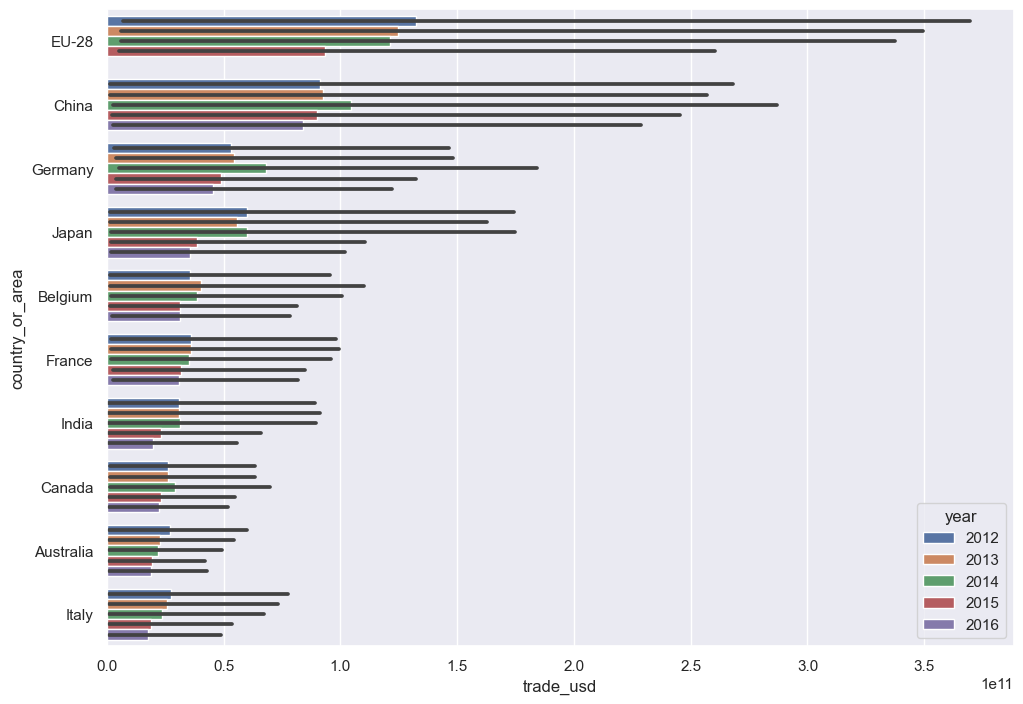

In [145]:
#plot top 10 country which have the highest trade value in dolar in total
years_fig1 = sns.barplot(data=top_10_usd, y='country_or_area',x='trade_usd', hue='year')
years_fig1 = years_fig1.get_figure()
years_fig1.savefig('years_fig1.png')

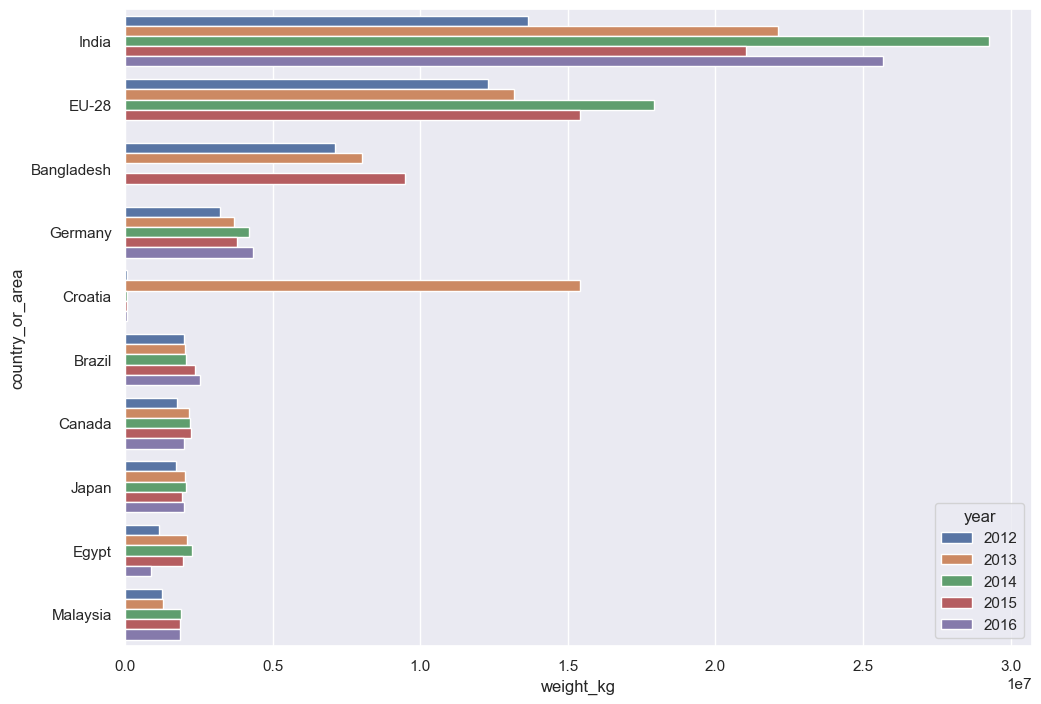

In [21]:
#plot top 10 country which have the highest trade volume in kg in total
years_fig2 = sns.barplot(data=top_10_kg, y='country_or_area',x='weight_kg', hue='year')
years_fig2 = years_fig2.get_figure()
years_fig2.savefig('years_fig2.png')

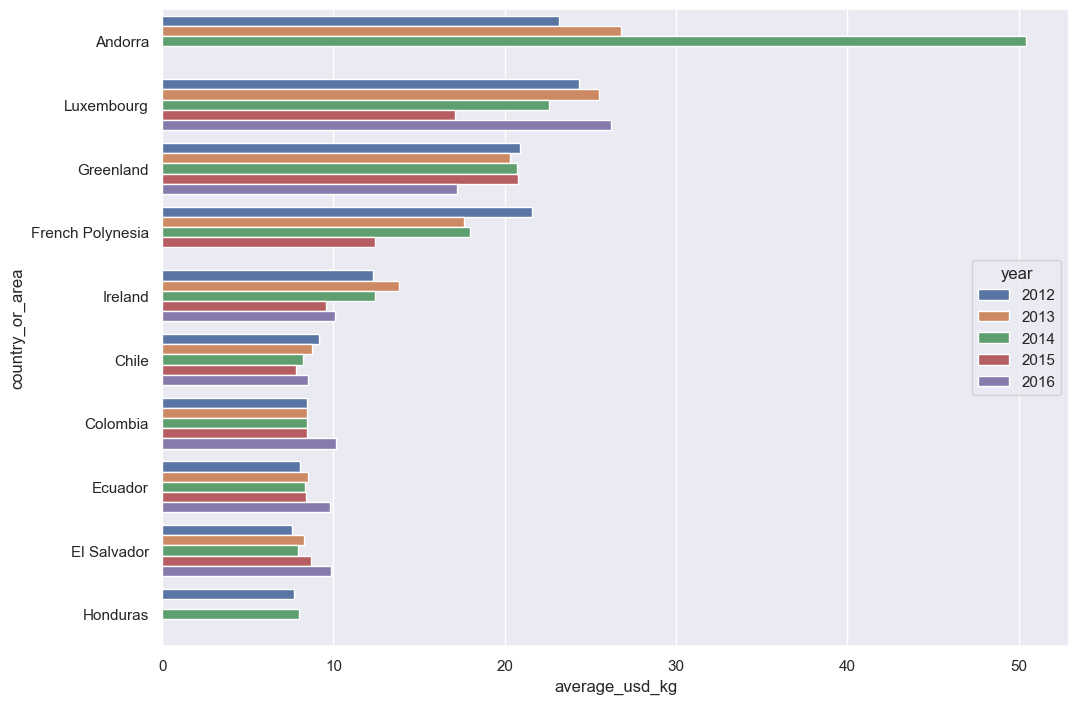

In [22]:
#plot the top 10 with highest price in average (median) for the last 5 years
years_fig3 = sns.barplot(data=top_10_price, y='country_or_area',x='average_usd_kg', hue='year')
years_fig3 = years_fig3.get_figure()
years_fig3.savefig('years_fig3.png')

C:\Users\Danang Prasetyanto\AppData\Local\Temp\ipykernel_24608\3061943001.py:12: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  dfc_eda = dfc_eda.groupby(['country_or_area','quantity_name','year','flow'],as_index=False)['weight_kg','trade_usd'].sum() #to aggregate weight and trade usd


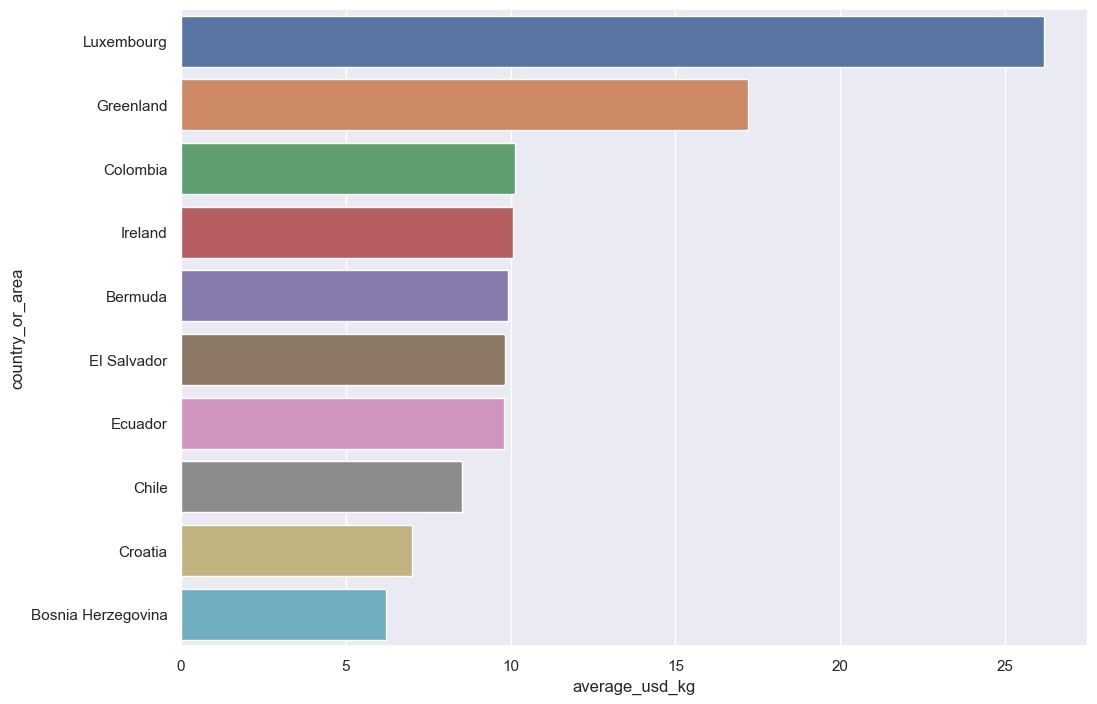

In [23]:
#find the latest top 10 country with highest average price
latest_price = ranks_latest(top_eda,'Rank_avg_usd_weight',ranks_flow)
latest_fig1 = sns.barplot(data=latest_price, y='country_or_area',x='average_usd_kg')
latest_fig1 = latest_fig1.get_figure()
latest_fig1.savefig('latest_fig1.png')

C:\Users\Danang Prasetyanto\AppData\Local\Temp\ipykernel_24608\3061943001.py:12: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  dfc_eda = dfc_eda.groupby(['country_or_area','quantity_name','year','flow'],as_index=False)['weight_kg','trade_usd'].sum() #to aggregate weight and trade usd


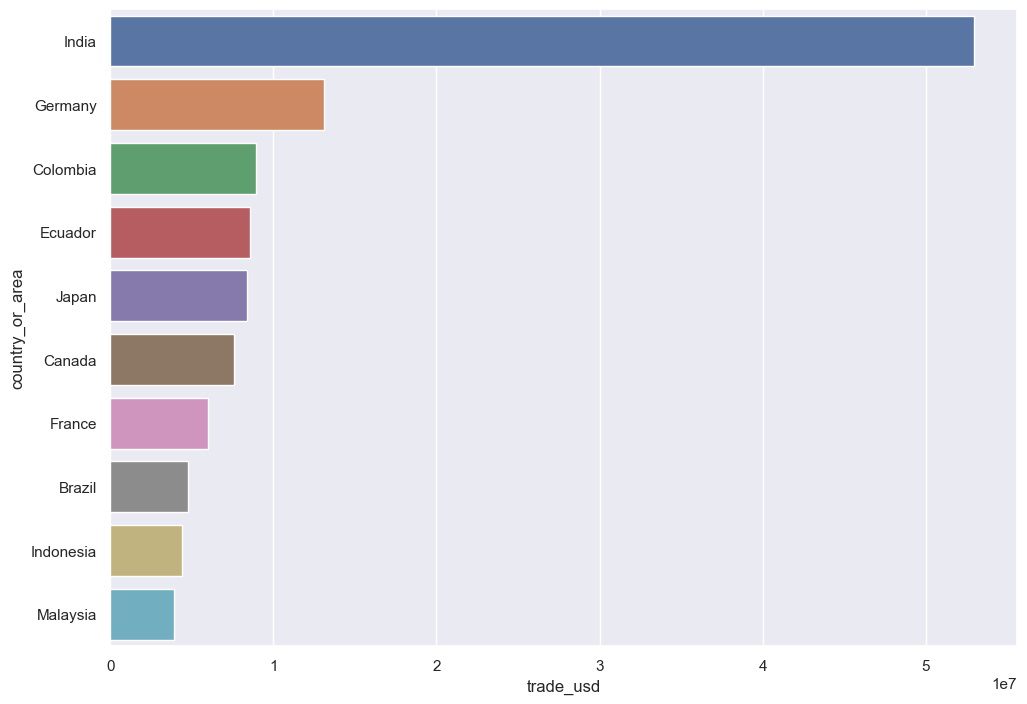

In [24]:
#find the latest top 10 country with highest value trade
latest_trade_usd = ranks_latest(top_eda,'Rank_trade_usd',ranks_flow)
latest_fig2 = sns.barplot(data=latest_trade_usd, y='country_or_area',x='trade_usd')
latest_fig2 = latest_fig2.get_figure()
latest_fig2.savefig('latest_fig2.png')

C:\Users\Danang Prasetyanto\AppData\Local\Temp\ipykernel_24608\3061943001.py:12: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  dfc_eda = dfc_eda.groupby(['country_or_area','quantity_name','year','flow'],as_index=False)['weight_kg','trade_usd'].sum() #to aggregate weight and trade usd


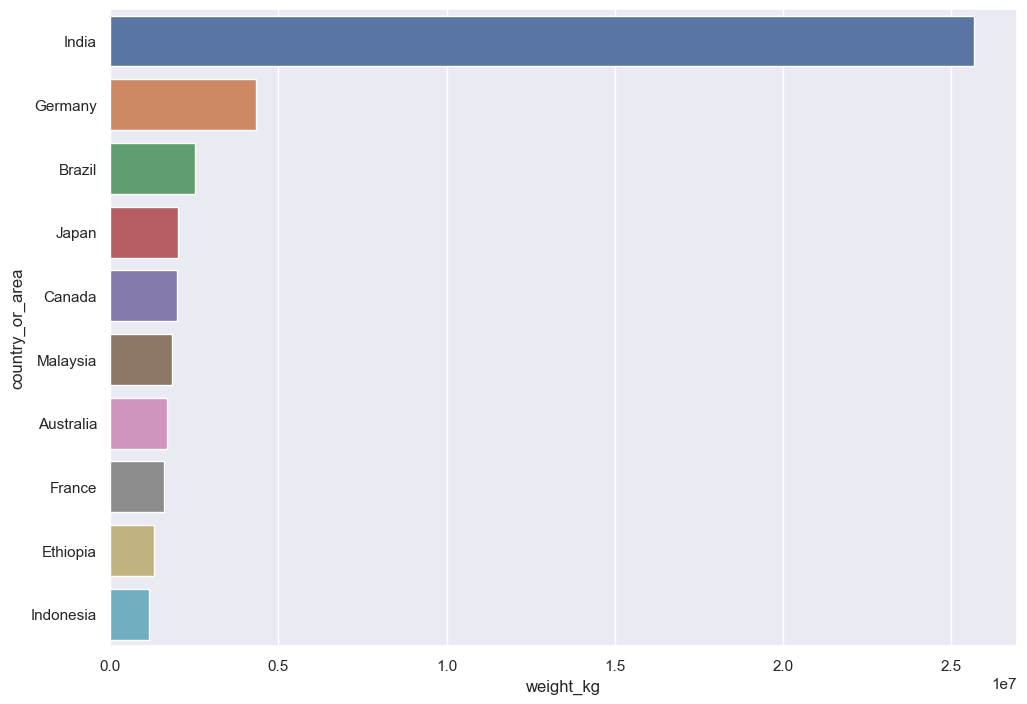

In [25]:
#find the latest top 10 country with highest volume trade
latest_weight_kg = ranks_latest(top_eda,'Rank_weight_kg',ranks_flow)
latest_fig3 = sns.barplot(data=latest_weight_kg, y='country_or_area',x='weight_kg')
latest_fig3 = latest_fig3.get_figure()
latest_fig3.savefig('latest_fig3.png')

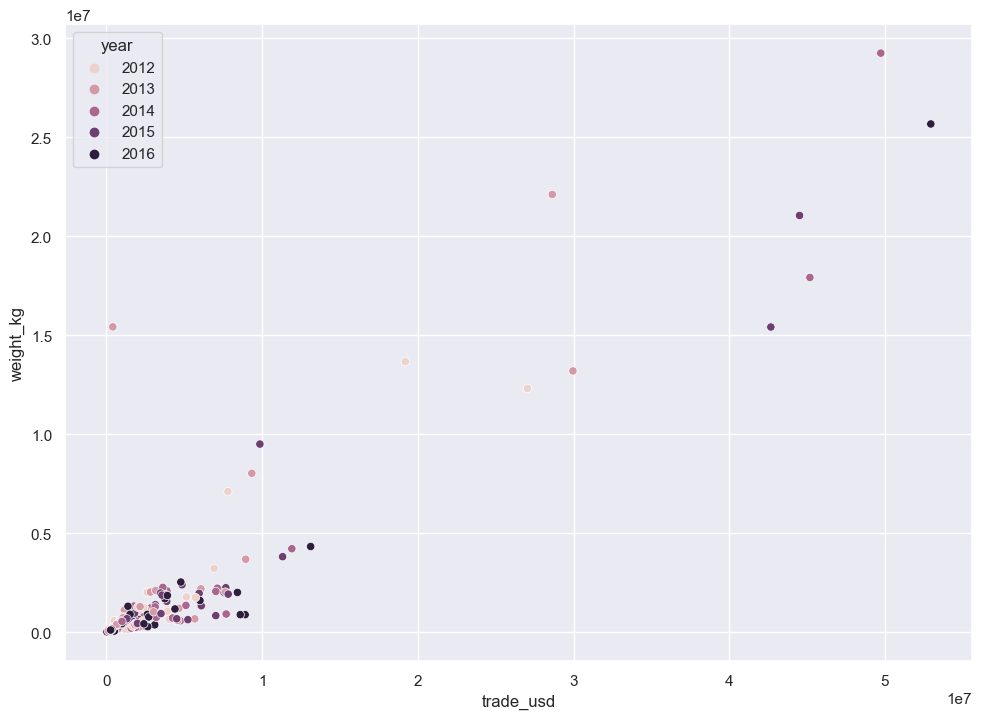

In [26]:
#check the correlation between weight and trade_usd
scatter_fig1 = sns.scatterplot(data=dfc_comm_eda,x='trade_usd', y='weight_kg', hue='year')
scatter_fig1 = scatter_fig1.get_figure()
scatter_fig1.savefig('scatter_fig1.png')